# Load Libs

In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns, keras
sns.set(style='white')

from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from matplotlib import pyplot as plt

from collections import OrderedDict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import dot, add, Lambda, Concatenate, multiply, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

np.set_printoptions(precision=4, suppress=True, linewidth=100)

Using TensorFlow backend.


# Data Preview

In [4]:
ratings = pd.read_csv('https://storage.googleapis.com/allianz-course/data/ratings.csv')
movies = pd.read_csv('https://storage.googleapis.com/allianz-course/data/movies.csv')

In [5]:
print(movies.shape)
movies.head()

(9125, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# Encode

In [7]:
# Fit user id and movie id
uid_enc, mid_enc = LabelEncoder(), LabelEncoder()
uid_enc.fit(ratings.userId)
mid_enc.fit(movies.movieId)

# Encode user id and movie id to indexed real value
ratings["userId"] = uid_enc.transform(ratings.userId)
ratings["movieId"] = mid_enc.transform(ratings.movieId)
movies["movieId"] = mid_enc.transform(movies.movieId)

# Dictionary of movie id and title
mid_map = pd.Series(dict(zip(movies.movieId, movies.title)))

# Number of users, number of movies
n_users, n_movies = len(uid_enc.classes_), len(mid_enc.classes_)

# Split Train, Test Data
* 以4分為閥值, 4分以上為positive, 未滿4分為negative
* 每個user分positive, negative兩部分, 各取30%到valid data

In [8]:
def split_ratings(data, pos_thres=4, test_ratio=0.3):
    """依照test_ratio切割movielens train test資料"""
    tr, te = [], []
    for u, df in data.groupby("userId"):
        if len(df) < 5: continue

        pos, neg = df.query("rating >= {}".format(pos_thres)), df.query("rating < {}".format(pos_thres))
        # Split positive part
        pos_len = int(len(pos) * (1 - test_ratio))
        tr_pos = pos[:pos_len]
        te_pos = pos[pos_len:]
        # Split negative part
        neg_len = int(len(neg) * (1 - test_ratio))
        tr_neg = neg[:neg_len]
        te_neg = neg[neg_len:]

        tr.append(tr_pos.append(tr_neg))
        te.append(te_pos.append(te_neg))
    return pd.concat(tr, ignore_index=True), pd.concat(te, ignore_index=True)

tr, te = split_ratings(ratings, 4, .3)

# Make Rating Matrix (Interaction Between Users and Movies)

In [9]:
tr_rating_mat = np.zeros((n_users, n_movies))
# Valid data rating matrix
te_rating_mat = np.zeros((n_users, n_movies))

# Train rating matrix
for idx, r in tr.iterrows():
    tr_rating_mat[int(r.userId), int(r.movieId)] = r.rating
# Valid rating matrix    
for idx, r in te.iterrows():
    te_rating_mat[int(r.userId), int(r.movieId)] = r.rating
    
print('Shape of train interaction matrix: ', tr_rating_mat.shape)
print(tr_rating_mat, '\n')
print('Shape of test interaction matrix: ', te_rating_mat.shape)
print(te_rating_mat)

Shape of train interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]] 

Shape of test interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Encode Movies Table

In [10]:
movies_encoded = movies.copy()
movies_encoded.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


# 以leave one out方式產生 train data, test data
1. 每一筆資料有兩部分: [user query] + [item id]
2. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
3. test data的user query來自於train data

In [62]:
def loo_preprocess(data, movies_encoded, train_hist=None, is_train=True):
    """以leave one out方式產生 train data, test data"""
    queue = []
    data = data.merge(movies_encoded, how="left", on="movieId")
    columns = ["user_id", "query_movie_ids", "query_movie_ids_len", 
               "candidate_movie_id",
               "rating"]
    
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        # 抓出user給予正向評價的電影 (>= 4)
        if is_train:
            fav_movies = set(df.query("rating >= 4").movieId)
        else:
            fav_movies = set(train_hist.query(f"userId == {u} and rating >= 4").movieId)
        for i, (_, r) in enumerate(df.iterrows()):
            queries = list(fav_movies - set([int(r.movieId)]))
            # 對於multivalent的欄位, 需要增加一個column去描述該欄位的長度
            queue.append([int(r.userId),
                          queries,
                          len(queries),
                          int(r.movieId), 
                          r.rating])
    return pd.DataFrame(queue, columns=columns)

trProcessed = loo_preprocess(tr, movies_encoded)
teProcessed = loo_preprocess(te, movies_encoded, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id,rating
0,0,[1515],1,931,4.0
1,0,[931],1,1515,4.0
2,0,"[931, 1515]",2,1083,3.5
3,0,"[931, 1515]",2,833,3.0
4,0,"[931, 1515]",2,859,3.0


In [63]:
teProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id,rating
0,0,"[931, 1515]",2,1665,4.0
1,0,"[931, 1515]",2,1708,3.0
2,0,"[931, 1515]",2,2925,3.0
3,0,"[931, 1515]",2,1962,2.5
4,0,"[931, 1515]",2,1743,2.0


## Data Function
1. 由於 Keras(Tensorflow backend) 不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: query_movie_ids, query_movie_ids_len

In [71]:
feats = ["query_movie_ids", "query_movie_ids_len", 
         "candidate_movie_id", 
         "global"]
multi_cols = ["query_movie_ids"]
label = 'rating'

# Generator function
def dataFn(data, n_batch=128, shuffle=False):
    pad = pad_sequences
    def fn():
        while True:
            dataInner = data.copy()
            indices = get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
            for ind in indices:
                ret = do_multi(dataInner.iloc[ind], multi_cols)
                ret['global'] = 100
                yield [np.stack(ret[col].values) if col in multi_cols else ret[col][:, None]
                       for col in feats], ret.rating.values[:, None]
    return fn

def get_minibatches_idx(n, batch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    minibatch_start = 0
    for i in range(n // batch_size):
        minibatches.append(idx_list[minibatch_start : minibatch_start + batch_size])
        minibatch_start += batch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])
    return minibatches

def do_multi(df, multi_cols):
    """Padding the multivalent feature"""
    pad = pad_sequences
    df = df.copy()
    for colname in multi_cols:
        lens = df[colname].map(len)
        df[colname] = list(pad(df[colname], padding="post", maxlen=lens.max()))
    return df

for data, label in dataFn(trProcessed, n_batch=3, shuffle=True)():
    break

for name, col in zip(feats, data):
    print(f'{name}\n{col}\n')
print(f'label\n{label}')

query_movie_ids
[[   0 4613 1035  526  528 1042  535 1056 2593 4642 4644 1572 1581 4654 5169 1078 5178 3140 1092
  2650 2651 5211 2653 2654 1636  101  626 4220 4221 2688  642 4743  141 2199 5274 3228 1185 2211
  2735  695 4804 1737 5323 2764 2769  724  725 1750  729 3803  731 4829  734 1756 1755 1761  740
   741  744  745  750 2287 2293 5367  766  767  770  771  774  775 3853  783  785 4376 1822 4383
  1313 1830 4912 2355 4934 4422 3917 2898 1876 1367 4960 4966  871 4976 2416 2930 3961 2428 4990
  4992  912 3987 5014 3485  419 5029 2471 2473  937 2993 2482 2994  947  951 2489  956  960  961
  5058  964  967  968  969 2506 4046  975 5072  977  978  984 2524 2534  999 1514 1002 5100 1517
  1006 1004 1008 1010 1012 1014 1017]
 [5127  274 1051 1572 4644 5165 3122 4917 5177 3898 4411  573 5184 3136 3394 4674 3653 2374 1358
  3157 2903 1628 2140 3422 2407 2409 3435  626 2169 4476 3197 5245 3199 4738 4739 3973  133 4231
  2187 4750 1689 4767 2723  932 3495 5288  935 5038 4271 3502 2478 5301  

In [72]:
tmp = pd.DataFrame()
for col, val in zip(feats, data):
    if col in multi_cols:
        tmp[col] = list(val)
    else:
        tmp[col] = val.ravel()

tmp['rating'] = label.ravel()
tmp

,query_movie_ids,query_movie_ids_len,candidate_movie_id,global,rating
0,"[0, 4613, 1035, 526, 528, 1042, 535, 1056, 259...",140,2380,100,3.0
1,"[5127, 274, 1051, 1572, 4644, 5165, 3122, 4917...",81,101,100,4.0
2,"[5633, 4610, 2563, 4611, 4613, 4101, 5638, 206...",140,5635,100,4.0


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Model of Matrix Factorization with Movie Histories

## Build Model Function

In [73]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_movie = Embedding(n_movies, emb_size, 
                          embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg),
                          input_length=1)(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(
            tf.sequence_mask(lens, dtype=tf.float32), 1)[:, :, tf.newaxis]
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    
    # Movie side
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))

    # Implements the formulation
    nets = dot([emb_query, emb_movie], -1)
    nets = add([nets, b_user, b_movie, b_global])
    
    model = Model([inp_query, 
                   inp_query_len,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model

batch_size = 128
epochs = 15
emb_size = 16
reg = 0.005
lr = 0.05

K.clear_session()
model_mf_dnn = get_model(n_users, n_movies, emb_size, reg)
model_mf_dnn.compile(optimizer=SGD(lr=lr), loss=keras.losses.mean_squared_error)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     146000      inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_len (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

# Training

## Use Callback Function
* keras.callbacks.ModelCheckpoint: 只存檔最好的結果, 是另一種防止overfitting的方式
    * save_best_only = True

In [74]:
model_dir = "./model_mf_history"

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

Epoch 1/15
543/543 [==============================] - 6s 11ms/step - loss: 2.1254 - val_loss: 1.6253
Epoch 2/15
543/543 [==============================] - 6s 10ms/step - loss: 1.5115 - val_loss: 1.4674
Epoch 3/15
253/543 [============>.................] - ETA: 2s - loss: 1.3975

KeyboardInterrupt: 

# Prediction

In [68]:
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()
print('Shape of test data: ', pred.shape)

Shape of test data:  (30605,)


# Metrics
* 定義4分以上為正向評價, 4分以下為負向評價

## RMSE 

In [38]:
te_len = len(teProcessed)
valis_steps = te_len // batch_size + (1 if te_len % batch_size else 0)

te_y = []
for i, (feat, label) in enumerate(dataFn(teProcessed, 
                                         n_batch=batch_size, 
                                         shuffle=False)(), 1):
    if i > valis_steps: break
    te_y += label.ravel().tolist()
    
te_y = np.array(te_y)
print("RMSE: ", np.sqrt(np.mean((pred - te_y)**2)))

RMSE:  0.9674408216326682


## AUC

auc: 0.7336645833837732


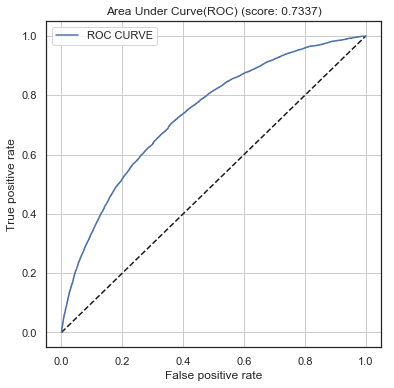

In [69]:
def draw_roc_curve(y, pred_proba):
    fpr, tpr, _ = roc_curve(y, pred_proba, pos_label=1)
    auc_scr = auc(fpr, tpr)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.grid(True)
    plt.show()
    
draw_roc_curve(te.rating >= 4, pred / pred.max())

## Single User Rating Histogram

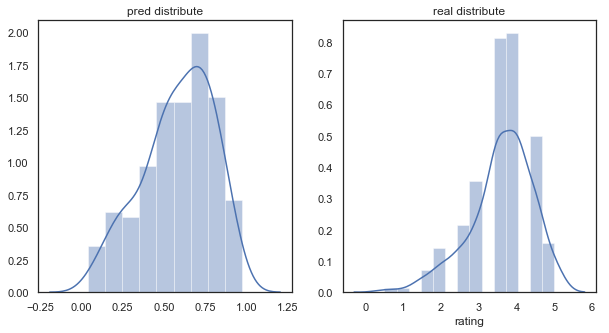

In [65]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
sns.distplot(single_pred, ax=ax[0])
ax[1].set_title("real distribute")
sns.distplot(te.query(f"userId == '{uid}'").rating, ax=ax[1])
plt.show()

## Single User Detail Table

In [33]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": tmp.candidate_movie_id,
              "title": mid_map[tmp.candidate_movie_id].values,
              "rating": tmp.rating.values,
              "predRating": single_pred},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.sort_values("rating", ascending=False)

,userId,movieId,title,rating,predRating
1224,22,4855,Kill Bill: Vol. 1 (2003),5.0,3.903784
1230,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,4.412870
1225,22,6132,Crash (2004),5.0,4.098488
1234,22,4371,Adaptation (2002),5.0,3.917500
1232,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,4.064291
1231,22,4432,City of God (Cidade de Deus) (2002),5.0,4.358509
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1229,22,5761,Duel (1971),5.0,4.182854
1228,22,4419,"Hours, The (2002)",5.0,3.939949
1227,22,4417,Catch Me If You Can (2002),5.0,4.076881


In [34]:
recommDf.sort_values("predRating", ascending=False)

,userId,movieId,title,rating,predRating
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1226,22,5623,Undertow (2004),5.0,5.144791
1283,22,4751,Ikiru (1952),4.0,4.972904
1296,22,3957,"Bad and the Beautiful, The (1952)",4.0,4.811474
1269,22,4724,Umberto D. (1952),4.5,4.698143
1331,22,5369,Viridiana (1961),3.5,4.682635
1316,22,5227,Zorba the Greek (Alexis Zorbas) (1964),4.0,4.675735
1281,22,6185,Last Days (2005),4.0,4.593620
1268,22,4241,Heaven (2002),4.5,4.578270
1322,22,5333,Sunrise: A Song of Two Humans (1927),4.0,4.558904


<br/>
<br/>
<br/>

# (LAB) 將Model從Regression改為Classification

## Modify Data Generator

In [70]:
# Generator function
def dataFn(data, n_batch=128, shuffle=False):
    pad = pad_sequences
    def fn():
        while True:
            dataInner = data.copy()
            indices = get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
            for ind in indices:
                ret = do_multi(dataInner.iloc[ind], multi_cols)
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in multi_cols else ret[col][:, None]
                       for col in feats], (ret.rating >= 4).astype(int)[:, None]
    return fn

for data, label in dataFn(trProcessed, n_batch=5, shuffle=False)():
    break

print(f'label\n{label}')

label
[[1]
 [1]
 [0]
 [0]
 [0]]


In [ ]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    # ...
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
# model_mf_dnn.compile(...)
###### END CODE HERE ######

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)

## 利用Movie Embedding, 以Cosine Similarity找出前10名相似電影

In [69]:
movies[movies.title.str.contains("Inception")]

,movieId,title,genres
7575,7575,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX


In [ ]:
# Call most_like function 找出前10名相似電影
# most_like(...)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

Epoch 7/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5792 - val_loss: 0.5787
Epoch 8/10
543/543 [==============================] - 7s 13ms/step - loss: 0.5759 - val_loss: 0.5780
Epoch 9/10
543/543 [==============================] - 7s 14ms/step - loss: 0.5734 - val_loss: 0.5797
Epoch 10/10
543/543 [==============================] - 7s 14ms/step - loss: 0.5709 - val_loss: 0.5898


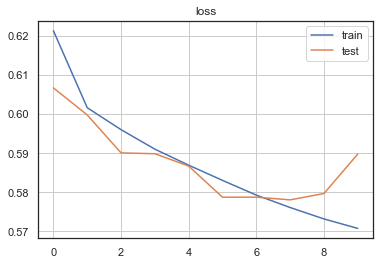

Shape of test data:  (30605,)
auc: 0.815732574814686


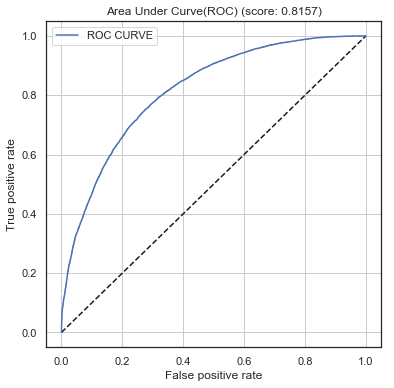

[[11465  3364]
 [ 4770 11006]]

             precision    recall  f1-score   support

      False       0.71      0.77      0.74     14829
       True       0.77      0.70      0.73     15776

avg / total       0.74      0.73      0.73     30605

[[0.9351 0.9685 0.8672 ... 0.9668 0.7024 0.9522]]


,movieId,title,genres
8787,8787,Ant-Man (2015),Action|Adventure|Sci-Fi
8582,8582,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi
8786,8786,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
8782,8782,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
8318,8318,Star Trek Into Darkness (2013),Action|Adventure|Sci-Fi|IMAX
8924,8924,Independence Day: Resurgence (2016),Action|Adventure|Sci-Fi
7412,7412,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
8459,8459,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
7729,7729,Limitless (2011),Sci-Fi|Thriller
8045,8045,Black Mirror (2011),Drama|Sci-Fi


In [78]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    nets = Activation("sigmoid")(nets)
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 10
lr = 0.05
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

model_mf_dnn.compile(optimizer=SGD(lr=lr), loss='binary_crossentropy')

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_y >= 4, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score)
print(confusion_matrix(te_y >= 4, pred >= 0.5))
print()
print(classification_report(te_y >= 4, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)

<br/>
<br/>
<br/>

# (LAB) 延續Classification, 以DNN作法取代MF作法

* Concatenate [user, movie], 且用 dense layer 增加hidden layers

In [ ]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu')(emb_query)
    emb_query = Dense(emb_size, activation='relu', name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu')(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', name='movie_impression')(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers
    # Maybe you need Dropout! BatchNormalization, etc..., try it for the better result!
    # nets = Concatenate(1)([emb_query, emb_movie])
    # nets = Dense(...)(nets)
    # ...
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
# model_mf.compile(...)
###### END CODE HERE ######

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)
# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score)
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

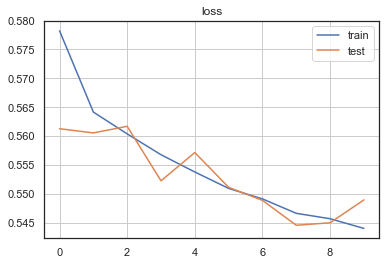

Shape of test data:  (30605,)
auc: 0.8183369434542288


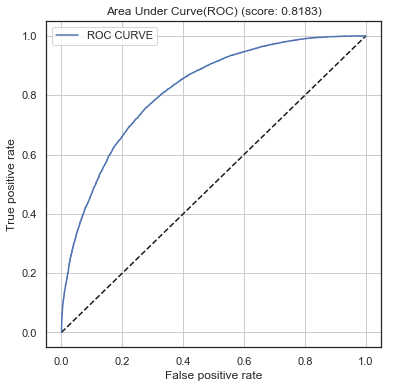

accuracy_score:  <function accuracy_score at 0x000001FA9A63EA60>
[[10708  4121]
 [ 3815 11961]]

             precision    recall  f1-score   support

          0       0.74      0.72      0.73     14829
          1       0.74      0.76      0.75     15776

avg / total       0.74      0.74      0.74     30605

[[0.7997 0.3005 0.2886 ... 0.8945 0.4467 0.2817]]


,movieId,title,genres
8787,8787,Ant-Man (2015),Action|Adventure|Sci-Fi
8582,8582,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi
8924,8924,Independence Day: Resurgence (2016),Action|Adventure|Sci-Fi
8786,8786,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
7729,7729,Limitless (2011),Sci-Fi|Thriller
8705,8705,Ex Machina (2015),Drama|Sci-Fi|Thriller
8782,8782,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
7856,7856,Rise of the Planet of the Apes (2011),Action|Drama|Sci-Fi|Thriller
7412,7412,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
8318,8318,Star Trek Into Darkness (2013),Action|Adventure|Sci-Fi|IMAX


In [85]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu')(emb_query)
    emb_query = Dense(emb_size, activation='relu', name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu')(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', name='movie_impression')(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers
    # Maybe you need Dropout! BatchNormalization, etc..., try it for the better result!
    nets = Concatenate(1)([emb_query, emb_movie])
    nets = Dense(32, activation='linear')(nets)
    nets = Activation('relu')(BatchNormalization()(nets))
    nets = Dense(16, activation='linear')(nets)
    nets = Activation('relu')(BatchNormalization()(nets))
    nets = Dense(1, activation='sigmoid')(nets)
    ###### END CODE HERE ######
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 10
lr = 0.05
###### END CODE HERE ######

model_dir = "./model_mf_dnn"
K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

model_mf_dnn.compile(optimizer=SGD(lr=lr), loss='binary_crossentropy')

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()


te_labels = (teProcessed.rating >= 4).astype(int)
# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_labels, pred)

# Confusion matrix, classification report
print('accuracy_score: ', accuracy_score)
print(confusion_matrix(te_labels, pred >= 0.5))
print()
print(classification_report(te_labels, pred >= 0.5))

most_like(model_emb_movie, 8787, k=11)